# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)

np.random.seed(42)
sns.set_style("whitegrid")


# Load Data

In [3]:
# Load processed data
df_final = pd.read_csv('../Assets/processed_reviews.csv.gz', compression='gzip')
print(f"Loaded processed_reviews.csv.gz: {len(df_final):,} reviews")

# Load split indices
with open('../Assets/split_indices.json', 'r') as f:
    split_data = json.load(f)
print("Loaded split_indices.json")

# Load domain stopwords (if exists)
try:
    with open('../Assets/domain_stopwords.json', 'r') as f:
        domain_stopwords = set(json.load(f))
    print(f"Loaded domain_stopwords.json: {len(domain_stopwords)} words")
except FileNotFoundError:
    print("No domain_stopwords.json found - using standard stopwords only")
    domain_stopwords = set()

# IMPORTANT: Create a mapping from old indices to new positions
# The CSV was saved without index, so we need to reconstruct the splits by position
old_to_new = {old_idx: new_pos for new_pos, old_idx in enumerate(df_final.index)}

# Convert old indices to positions in the current dataframe
train_positions = [i for i, idx in enumerate(df_final.index) if i < len(split_data['train_indices'])]
val_positions = [i for i, idx in enumerate(df_final.index) if len(split_data['train_indices']) <= i < len(split_data['train_indices']) + len(split_data['val_indices'])]
test_positions = [i for i, idx in enumerate(df_final.index) if i >= len(split_data['train_indices']) + len(split_data['val_indices'])]

# Actually, let's use a simpler approach - just recreate the splits using the counts
n_train = len(split_data['train_indices'])
n_val = len(split_data['val_indices'])
n_test = len(split_data['test_indices'])

# Use iloc for positional indexing
X_train = df_final.iloc[:n_train]['text_final']
y_train = df_final.iloc[:n_train]['sentiment']

X_val = df_final.iloc[n_train:n_train+n_val]['text_final']
y_val = df_final.iloc[n_train:n_train+n_val]['sentiment']

X_test = df_final.iloc[n_train+n_val:]['text_final']
y_test = df_final.iloc[n_train+n_val:]['sentiment']

print(f"Training:   {len(X_train):,} reviews")
print(f"Validation: {len(X_val):,} reviews")
print(f"Test:       {len(X_test):,} reviews")
print(f"\nPositive: {(y_train==1).sum():,} | Negative: {(y_train==0).sum():,}")
print(f"Class ratio: {(y_train==1).sum() / (y_train==0).sum():.1f}:1")

Loaded processed_reviews.csv.gz: 436,836 reviews
Loaded split_indices.json
Loaded domain_stopwords.json: 104 words
Training:   262,101 reviews
Validation: 87,367 reviews
Test:       87,368 reviews

Positive: 189,546 | Negative: 72,555
Class ratio: 2.6:1


# TF-IDF

In [4]:
# Create TF-IDF features
combined_stopwords = list(ENGLISH_STOP_WORDS.union(domain_stopwords))

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8,
    stop_words=combined_stopwords,
    token_pattern=r'\b[a-zA-Z]{3,}\b'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

print(f"Vocabulary: {len(tfidf.vocabulary_):,} words")

Vocabulary: 20,000 words


# Train Model

In [5]:
# Train Logistic Regression
lr = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',
    C=1.0,
    solver='liblinear'
)

lr.fit(X_train_tfidf, y_train)
y_val_pred = lr.predict(X_val_tfidf)

# Metrics
acc = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
prec = precision_score(y_val, y_val_pred)
rec = recall_score(y_val, y_val_pred)

print(f"Validation Accuracy: {acc:.1%}")
print(f"F1-Score: {f1:.4f}")
print("\n" + classification_report(y_val, y_val_pred, 
                                   target_names=['Negative', 'Positive']))

Validation Accuracy: 92.9%
F1-Score: 0.9496

              precision    recall  f1-score   support

    Negative       0.83      0.93      0.88     24164
    Positive       0.97      0.93      0.95     63203

    accuracy                           0.93     87367
   macro avg       0.90      0.93      0.91     87367
weighted avg       0.93      0.93      0.93     87367



# Confusion Matrix

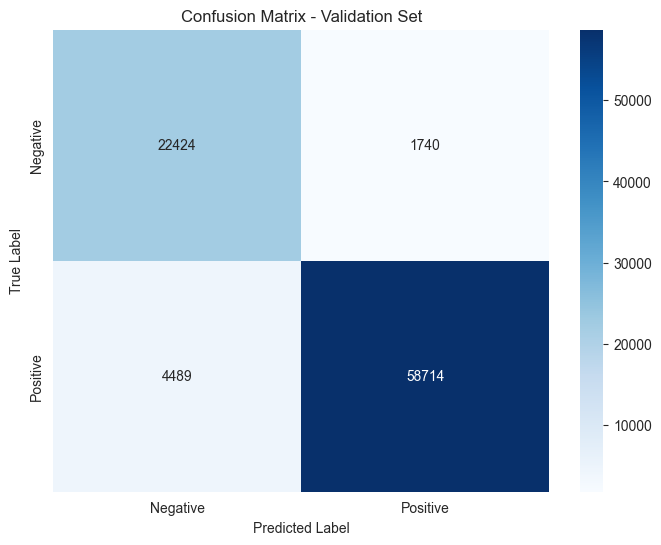

In [6]:
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Negative', 'Positive'],
           yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
import os
os.makedirs('../Images', exist_ok=True)
plt.savefig('../Images/confusion_matrix_val.png', dpi=300, bbox_inches='tight')
plt.show()

# Extract Top Words

In [7]:
# Extract feature importance
feature_names = tfidf.get_feature_names_out()
coefficients = lr.coef_[0]

feature_df = pd.DataFrame({
    'word': feature_names,
    'coefficient': coefficients
}).sort_values('coefficient', ascending=False)

print("TOP 20 POSITIVE WORDS:")
print(feature_df.head(20)[['word', 'coefficient']])

print("\nTOP 20 NEGATIVE WORDS:")
print(feature_df.tail(20)[['word', 'coefficient']])

feature_df.to_csv('../Assets/feature_importance.csv', index=False)

TOP 20 POSITIVE WORDS:
                  word  coefficient
388            amazing    16.429780
7465             great    15.127507
1127           awesome    12.321221
10613            loved    10.745562
2084             cares    10.428559
5040           enjoyed     9.487839
1397              best     8.829495
5387         excellent     8.706289
4402              easy     8.510771
2202            caring     8.203189
19539        wonderful     7.917045
5819         fantastic     7.587271
9056       interesting     7.433300
6544               fun     7.171976
10573             love     7.032810
8096            helped     6.995837
15877            solid     6.939506
8236             helps     6.928240
19428          willing     6.770406
16155  straightforward     6.616169

TOP 20 NEGATIVE WORDS:
                 word  coefficient
1255           barely    -5.663833
14322           reads    -5.990061
3145        confusing    -6.007334
18724         useless    -6.008007
10689            luck 

# Visualize Top Words

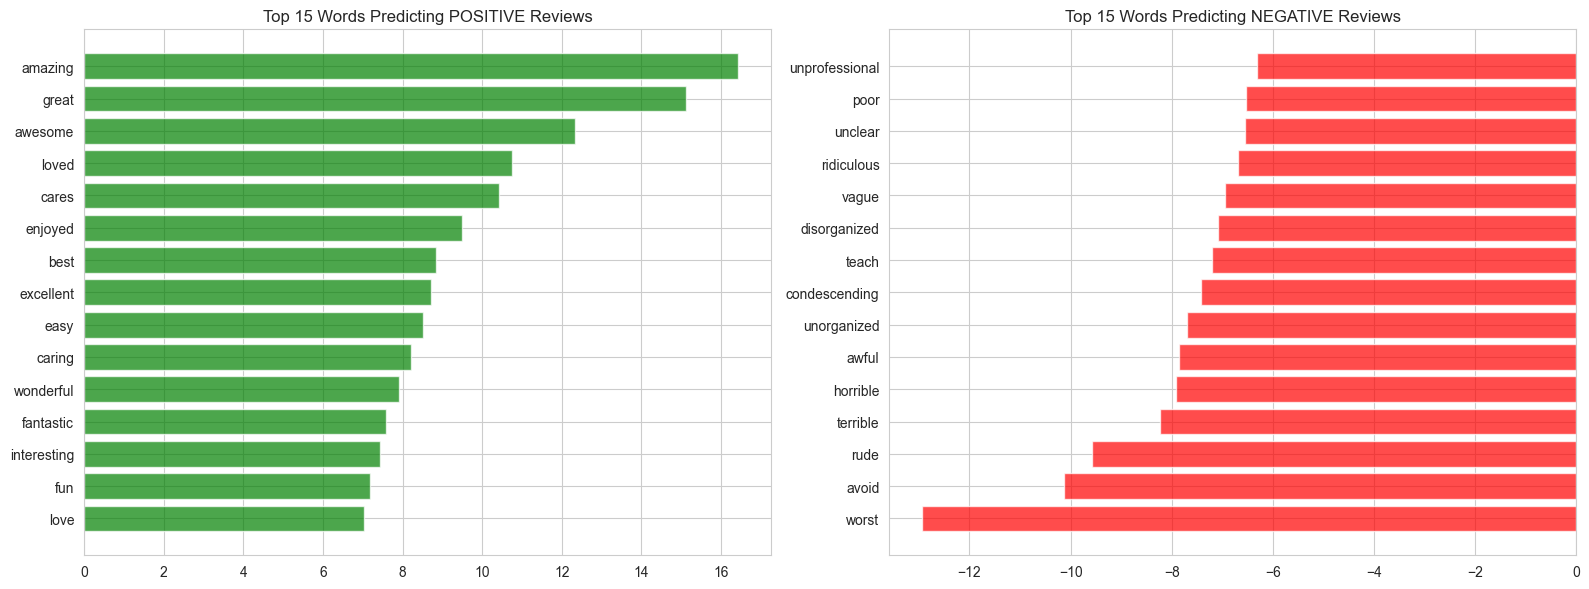

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Positive words
top_pos = feature_df.head(15)
axes[0].barh(range(len(top_pos)), top_pos['coefficient'], color='green', alpha=0.7)
axes[0].set_yticks(range(len(top_pos)))
axes[0].set_yticklabels(top_pos['word'])
axes[0].set_title('Top 15 Words Predicting POSITIVE Reviews')
axes[0].invert_yaxis()

# Negative words
top_neg = feature_df.tail(15)
axes[1].barh(range(len(top_neg)), top_neg['coefficient'], color='red', alpha=0.7)
axes[1].set_yticks(range(len(top_neg)))
axes[1].set_yticklabels(top_neg['word'])
axes[1].set_title('Top 15 Words Predicting NEGATIVE Reviews')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../Images/actionable_feedback.png', dpi=300, bbox_inches='tight')
plt.show()

# Save Models

In [9]:
# Save models
with open('../Assets/model_lr.pkl', 'wb') as f:
    pickle.dump(lr, f)
with open('../Assets/vectorizer_tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# Save results
week4_results = {
    'validation_accuracy': float(acc),
    'validation_f1': float(f1),
    'top_10_positive': feature_df.head(10)['word'].tolist(),
    'top_10_negative': feature_df.tail(10)['word'].tolist()
}
with open('../Assets/week4_results.json', 'w') as f:
    json.dump(week4_results, f, indent=2)
